<h1>Regressions with ANN<br /><small>Jonah Williams</small></h1>

In [1]:
import theano
import numpy as np
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams

import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

<h3>Rectifier Linear Unit (ReLU)</h3>
One of the limitations for sigmoid and hyperbolic tangent activations for deeper networks is the tendency of gradients to saturate - preventing lower layers from recieving any signal from the error.  Unsupervised pretraining is one solution - another is the use of linear activation units.

$$y = max(x \cdot W + b, 0) $$

This is the standard recifier linear unit.  There are also modifications called the leaky ReLU

$$y = max(x \cdot W + b, -c) $$

Where c is a small constant (-0.01 for example).  This prevents ReLU units from dying.

In [10]:
def ReLU(x):
    return 0.5 * (x + abs(x))

class Layer(object):
    def __init__(self, input, num_in, num_out,
                 W=None, b=None, activation=T.nnet.sigmoid):
        self.np_rng = np.random.RandomState(1234)
        self.theano_rng = RandomStreams(np_rng.randint(1234))
        if not W:
            W = np.asarray(np_rng.uniform(
                                   low=-np.sqrt(6. / (num_in + num_out)),
                                   high=np.sqrt(6. / (num_in + num_out)),
                                   size=(num_in, num_out)),
                       dtype=theano.config.floatX)
        if not b:
            b = np.zeros((num_out,), dtype=theano.config.floatX)
        
        self.input = input
        self.W = theano.shared(value=W, name='W', borrow=True)
        self.b = theano.shared(value=b, name='b', borrow=True)
        if not activation:
            self.output = T.dot(input, self.W) + self.b
        else:
            self.output = activation(T.dot(input, self.W) + self.b)
        self.params = [self.W, self.b]
        self.L2 = T.sum(self.W**2)

        
def _dropout(self, p, layer, theano_rng):
    theano_rng.binomial(n=1, p=1-p, size=layer.shape)
    return layer * T.cast(mask, theano.config.floatX)
        
   

In [93]:
df = pd.read_csv('/Users/jonahwilliams/Downloads/motor.csv')
df.head()

,Unnamed: 0,times,accel,strata,v
0,1,2.4,0.0,1,3.7
1,2,2.6,-1.3,1,3.7
2,3,3.2,-2.7,1,3.7
3,4,3.6,0.0,1,3.7
4,5,4.0,-2.7,1,3.7


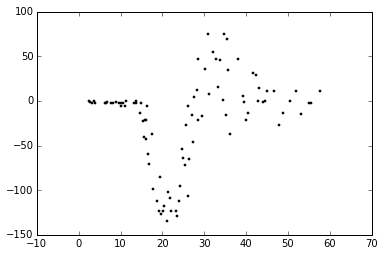

In [94]:
plt.scatter(df['times'], df['accel'], s=3, color="black")
plt.show()

In [96]:
data = df[['times','accel']].values
np.random.shuffle(data)
x_set = data[:,0]
y_set = data[:,1]


x_set = theano.shared(np.asarray(x_set, dtype=theano.config.floatX), borrow=True)
y_set = theano.shared(np.asarray(y_set, dtype=theano.config.floatX), borrow=True)

In [97]:
x = T.matrix('x')
np_rng = np.random.RandomState(12345)


class RegressionNetwork(object):
    
    def __init__(self, input_size=1, output_size=1,
                 hidden_sizes=[1000,1000],
                 weight_decay = 0.01,
                 np_rng=np.random.RandomState(12345)):
        
        
        self.x = T.dscalar('x')
        self.y = T.dscalar('y')
        self.input = self.x
        self.layers = []
        self.params = []

        
        for i in xrange(len(hidden_sizes)):
            
            if i == 0:
                layer_input = self.input
                num_in = input_size
                num_out = hidden_sizes[i]
            else:
                layer_input = self.layers[-1].output
                num_in = hidden_sizes[i - 1]
                num_out = hidden_sizes[i]
                
            layer = Layer(input=layer_input,
                         num_in=num_in,
                         num_out=num_out,
                         activation=T.tanh)
            self.layers.append(layer)
            self.params.extend(layer.params)
        

        self.output_layer = Layer(input=self.layers[-1].output,
                                  num_in=hidden_sizes[-1],
                                  num_out=output_size,
                                  activation=None)
        self.layers.append(self.output_layer)
        self.params.extend(self.output_layer.params)
        self.L2 = sum([l.L2 for l in self.layers])

        if weight_decay:
            self.cost = T.mean((self.output_layer.output - self.y)**2) + weight_decay * self.L2
        else:
            self.cost = T.mean((self.output_layer.output - self.y)**2)
        
    
    def training(self, dataset, learning_rate=0.01):
        set_x, set_y = dataset
        index = T.iscalar("index")
        gparams = T.grad(self.cost, self.params)
        updates = [
            (param, param - gparam * learning_rate)
            for param, gparam in zip(self.params, gparams)
        ]
        
        train = theano.function(
            inputs=[index],
            outputs=self.cost,
            updates=updates,
            givens={
                self.x: set_x[index],
                self.y: set_y[index]
            },
            name='train'
        )
        return train  
    def predict(self, x):
        index = T.iscalar("index")
        predict = theano.function(
            inputs=[index],
            outputs=self.output_layer.output,
            givens={
                self.x: x[index]
            },
            name='predict'
        )
        return predict
    

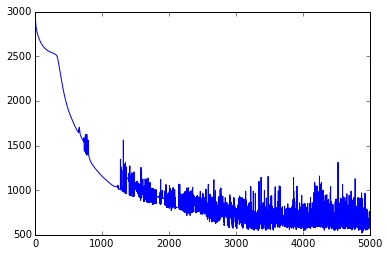

In [125]:
Model = RegressionNetwork(1, 1, hidden_sizes=[256, 128, 64, 32], weight_decay=None)
train = Model.training(dataset=(x_set, y_set), learning_rate=0.000001)

errors = []
for epoch in xrange(5000):
    error = 0.0
    for i in xrange(len(df)):
        error += train(i)
    errors.append(error / 94.0)
plt.plot(errors)

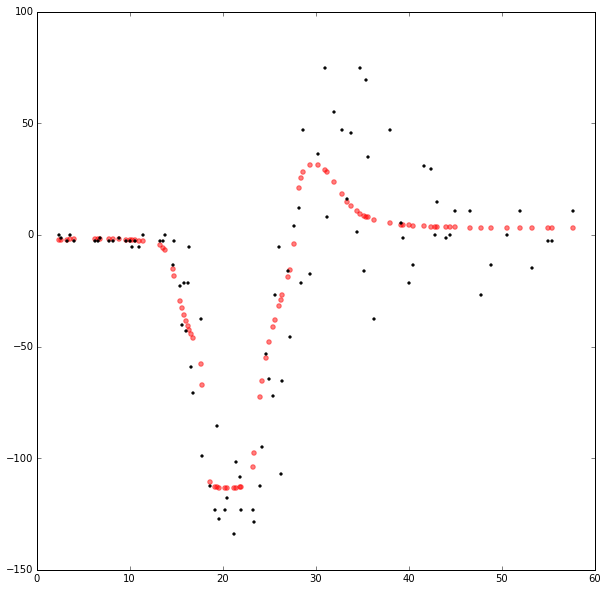

In [126]:
prediction = Model.predict(x_set)

plt.figure(figsize=(10, 10))
plt.scatter(data[:,0],[prediction(i)[0] for i in xrange(94)], color="red", alpha=0.5)
plt.scatter(data[:,0], data[:,1], color="black", s=5)
plt.xlim(0, 60)
plt.show()

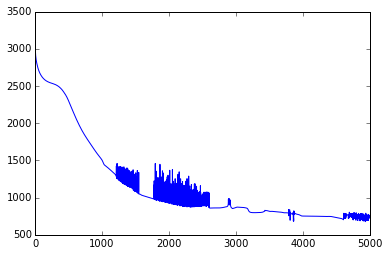

In [127]:
Model = RegressionNetwork(1, 1, hidden_sizes=[128, 64, 32], weight_decay=None)
train = Model.training(dataset=(x_set, y_set), learning_rate=0.000001)

errors = []
for epoch in xrange(5000):
    error = 0.0
    for i in xrange(len(df)):
        error += train(i)
    errors.append(error / 94.0)
plt.plot(errors)

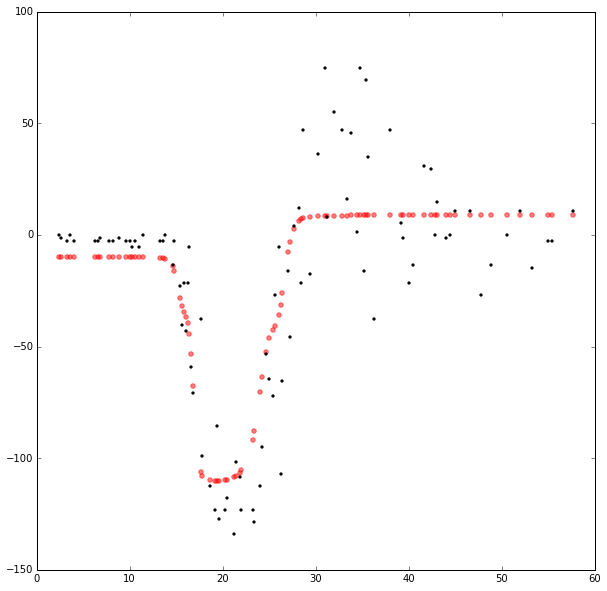

In [128]:
prediction = Model.predict(x_set)

plt.figure(figsize=(10, 10))
plt.scatter(data[:,0],[prediction(i)[0] for i in xrange(94)], color="red", alpha=0.5)
plt.scatter(data[:,0], data[:,1], color="black", s=5)
plt.xlim(0, 60)
plt.show()

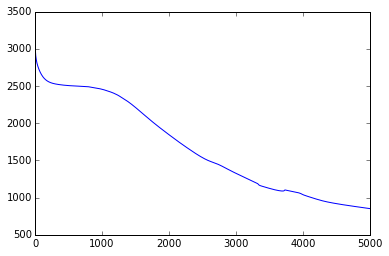

In [129]:
Model = RegressionNetwork(1, 1, hidden_sizes=[64, 32], weight_decay=None)
train = Model.training(dataset=(x_set, y_set), learning_rate=0.000001)

errors = []
for epoch in xrange(5000):
    error = 0.0
    for i in xrange(len(df)):
        error += train(i)
    errors.append(error / 94.0)
plt.plot(errors)

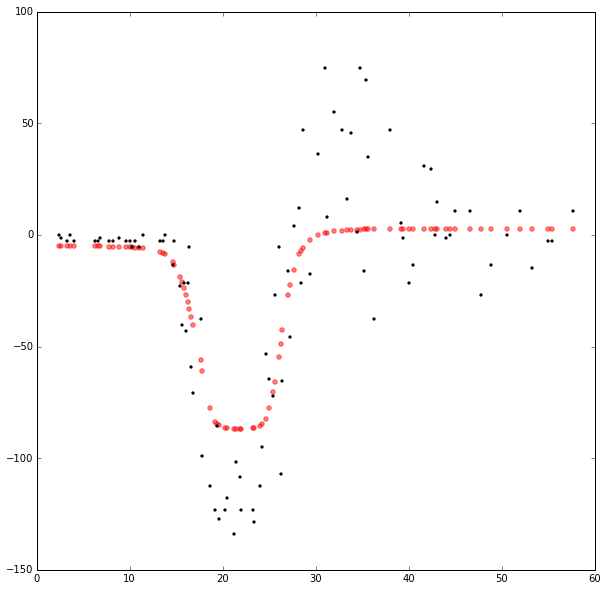

In [130]:
prediction = Model.predict(x_set)

plt.figure(figsize=(10, 10))
plt.scatter(data[:,0],[prediction(i)[0] for i in xrange(94)], color="red", alpha=0.5)
plt.scatter(data[:,0], data[:,1], color="black", s=5)
plt.xlim(0, 60)
plt.show()

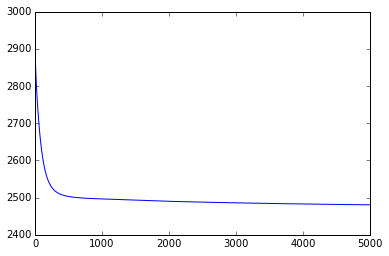

In [131]:
Model = RegressionNetwork(1, 1, hidden_sizes=[32], weight_decay=None)
train = Model.training(dataset=(x_set, y_set), learning_rate=0.000001)

errors = []
for epoch in xrange(5000):
    error = 0.0
    for i in xrange(len(df)):
        error += train(i)
    errors.append(error / 94.0)
plt.plot(errors)

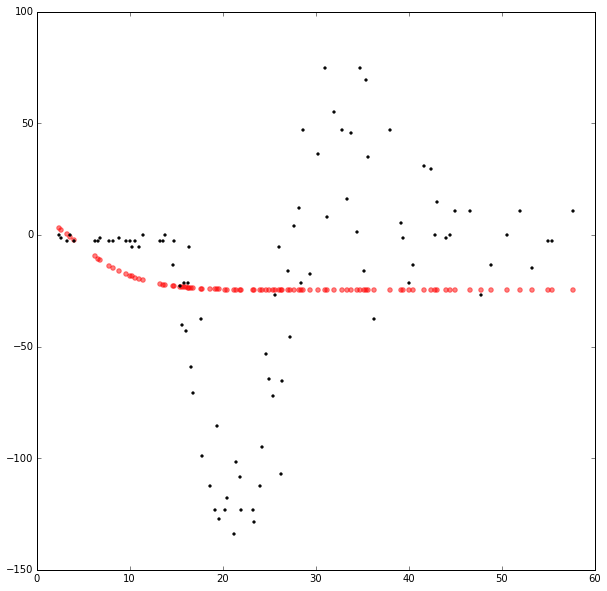

In [132]:
prediction = Model.predict(x_set)

plt.figure(figsize=(10, 10))
plt.scatter(data[:,0],[prediction(i)[0] for i in xrange(94)], color="red", alpha=0.5)
plt.scatter(data[:,0], data[:,1], color="black", s=5)
plt.xlim(0, 60)
plt.show()

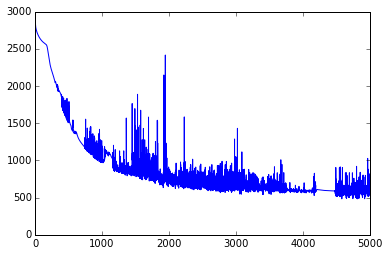

In [133]:
Model = RegressionNetwork(1, 1, hidden_sizes=[512, 256, 128, 64, 32], weight_decay=None)
train = Model.training(dataset=(x_set, y_set), learning_rate=0.000001)

errors = []
for epoch in xrange(5000):
    error = 0.0
    for i in xrange(len(df)):
        error += train(i)
    errors.append(error / 94.0)
plt.plot(errors)

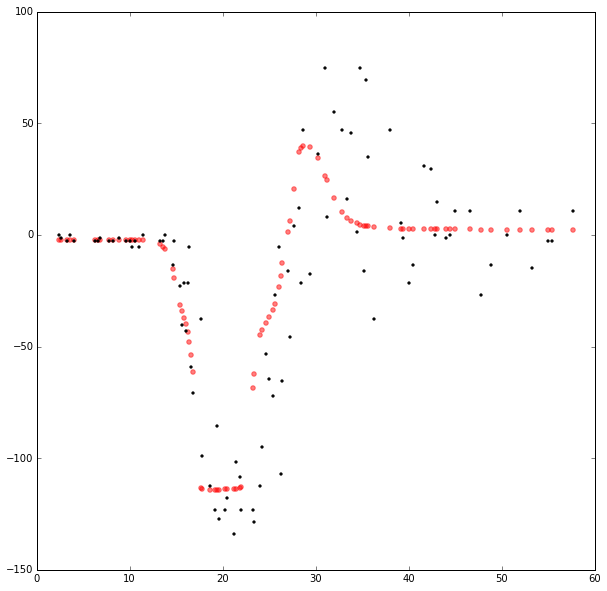

In [134]:
prediction = Model.predict(x_set)

plt.figure(figsize=(10, 10))
plt.scatter(data[:,0],[prediction(i)[0] for i in xrange(94)], color="red", alpha=0.5)
plt.scatter(data[:,0], data[:,1], color="black", s=5)
plt.xlim(0, 60)
plt.show()